In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests

colours = [(230, 63, 7), (48, 18, 59), (68, 81, 191), (69, 138, 252), (37, 192, 231), 
           (31, 233, 175), (101, 253, 105), (175, 250, 55), (227, 219, 56), (253, 172, 52),
           (246, 108, 25), (216, 55, 6), (164, 19, 1), (90, 66, 98), (105, 116, 203), 
           (106, 161, 253), (81, 205, 236), (76, 237, 191), (132, 253, 135), (191, 251, 95),
           (233, 226, 96), (254, 189, 93), (248, 137, 71), (224, 95, 56), (182, 66, 52), 
           (230, 63, 7), (48, 18, 59), (68, 81, 191), (69, 138, 252), (37, 192, 231), 
           (31, 233, 175), (101, 253, 105), (175, 250, 55), (227, 219, 56), (253, 172, 52),
           (246, 108, 25), (216, 55, 6), (164, 19, 1), (90, 66, 98), (105, 116, 203), 
           (106, 161, 253), (81, 205, 236), (76, 237, 191), (132, 253, 135), (191, 251, 95), 
           (233, 226, 96), (254, 189, 93), (248, 137, 71), (224, 95, 56), (182, 66, 52)]

## Processing incoming async frames at once

In [2]:
num_imgs = 16
arangement = (4,4)

img_width = 320
img_height = 240

merged_img_arr = np.zeros( ( img_height * arangement[1], img_width * arangement[0]))
print(f"Stacked grid of image dimension {merged_img_arr.shape} \n-- {num_imgs} arranged {arangement} ")
# display(merged_img_arr)

Stacked grid of image dimension (960, 1280) 
-- 16 arranged (4, 4) 


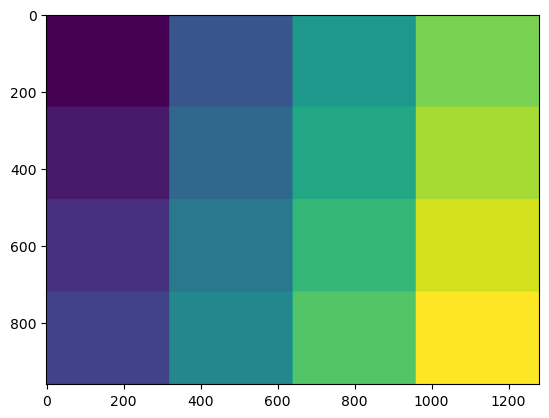

In [3]:
def display(img):
    # Util function for plotting, not used in production
    plt.imshow(img)
    plt.show()
    
def write_slice_from_id(array, id, data=1):
    # Concurrent safe write to shared combo-data array
    row = (id // arangement[0]) * img_width
    col = (id % arangement[1]) * img_height
    arr = array.copy()
    arr[col:col+img_height,row:row+img_width] = data
    return arr

def read_slice_from_id(arr, id):
    # Concurrent safe write to shared combo-data array
    row = (id // arangement[0]) * img_width
    col = (id % arangement[1]) * img_height
    return arr[col:col+img_height,row:row+img_width]

area_bounds = merged_img_arr.copy()
for i in range(num_imgs):
     area_bounds = write_slice_from_id(area_bounds, i, data=i)
display(area_bounds)


def get_areaID_by_coordinate(x, y) -> int:
    # Safe constant time reads from combo data
    global area_bounds
    return area_bounds[x][y]

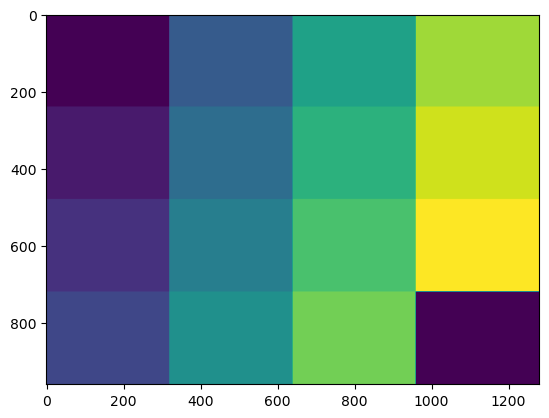

In [4]:
new_img = np.zeros((img_height, img_width))
updated = write_slice_from_id(area_bounds, 15, data=new_img)
display(updated)

In [5]:
read_slice_from_id(area_bounds, 15).shape

(240, 320)

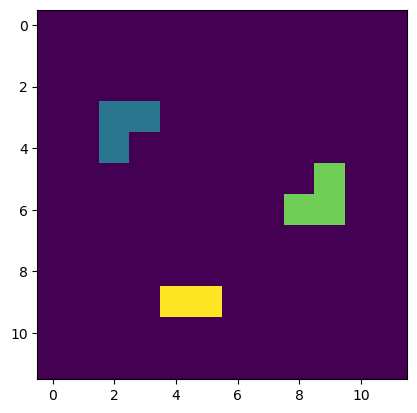

In [6]:
example_blobs = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 100., 100., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 100., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 200., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 200., 200., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 255., 255., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], np.uint8)
display(example_blobs)

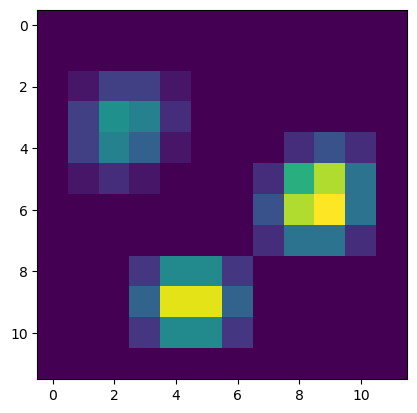

In [7]:
blur = cv2.GaussianBlur(example_blobs.copy(), (3, 3), 0)
# blur = example_blobs.copy()
display(blur)

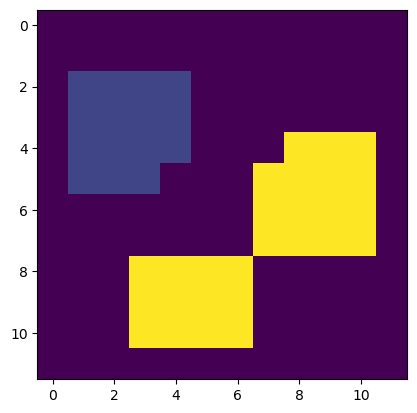

In [8]:
contours, hierarchy= cv2.findContours(blur.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
blobs_contoured = example_blobs.copy()

for i in range(len(sorted_contours)):    
    cv2.drawContours(blobs_contoured, [sorted_contours[i]], -1, colours[i], -1)
display(blobs_contoured)

In [9]:
state = dict(zip(range(num_imgs), [False] * num_imgs))
point_contours = np.vstack(contours).squeeze()

for point in  point_contours:
    state[get_areaID_by_coordinate(point[0], point[1])] = True
state

{0: True,
 1: False,
 2: False,
 3: False,
 4: False,
 5: False,
 6: False,
 7: False,
 8: False,
 9: False,
 10: False,
 11: False,
 12: False,
 13: False,
 14: False,
 15: False}

## Capturing data from embedded devices

### Device ID

In [10]:
device_webserver = 'http://192.168.0.100'

In [12]:
res = requests.get(f"{device_webserver}/id")

In [13]:
res.text

'Device ID: 8'

### Video frames

In [14]:
test_img = None

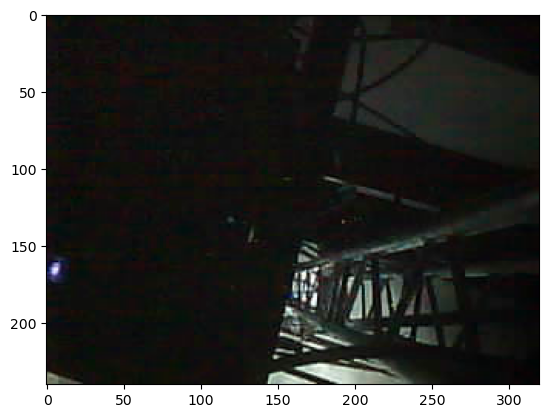

In [15]:
video = cv2.VideoCapture(device_webserver)

while True:
    ret, frame = video.read()
    
    if ret:
        test_img = frame
        display(frame)
        video.release()
        break


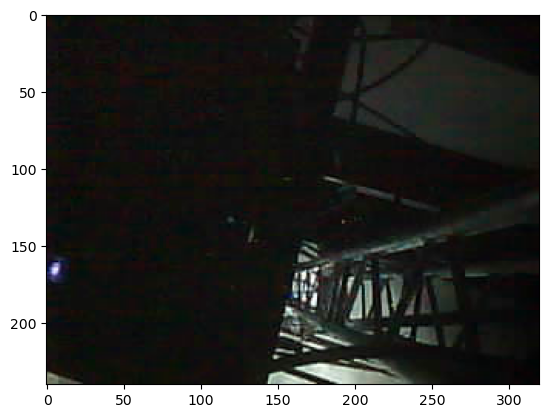

In [16]:
plt.imshow(test_img)
plt.savefig('test_capture.png')
plt.show()

In [17]:
def detect_change(refFrame, curFrame):
    # Blur to reduce noise
#     refFrame = cv2.GaussianBlur(refFrame, (5,5), 0)
#     curFrame = cv2.GaussianBlur(curFrame, (5,5), 0)
    
    # Calculate the absolute difference between the images
    difference = cv2.absdiff(refFrame, curFrame)
    
    # Threshold the difference image
    _, difference = cv2.threshold(difference, 15, 255, cv2.THRESH_BINARY)
#     print(difference)
    
    # Dilate the difference image to amplify the changes
    kernel = np.ones((1, 1), np.uint8)
    difference = cv2.dilate(difference, kernel, iterations=3)

    plt.imshow(difference, cmap='gray')
    plt.show()
    return True if cv2.countNonZero(difference) > 0 else False

In [18]:
ref = plt.imread('../tmp/1/0.png')
# change = plt.imread('../tmp/1/10.png')
nochange = plt.imread('../tmp/1/3.png')

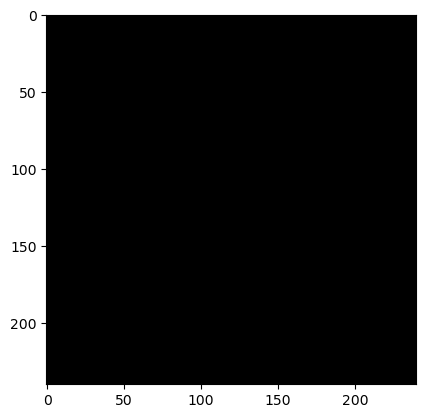

False

In [19]:
detect_change(ref, nochange)

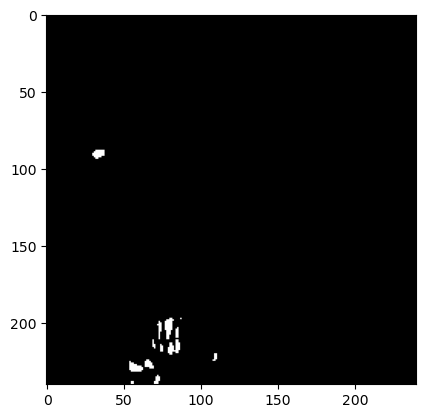

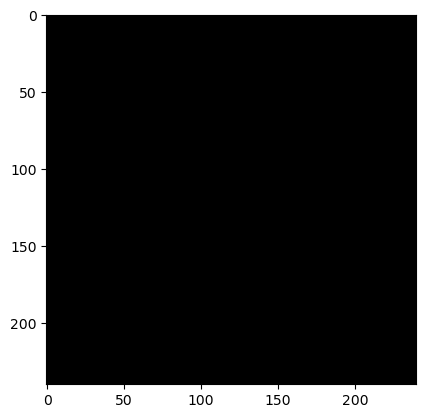

OK


In [134]:
print('OK' if detect_change(ref, change) == True and detect_change(ref, nochange) == False else 'ERR')